# RNN архитектуры

Гриневская Катя, БКЛ182

### Задание 2.
Проанализируйте и сделайте препроцессинг на основании вашего анализа и того дизайна экспериментов, который описан в статье

Загружаем данные

In [3]:
import pandas as pd

In [4]:
news = pd.read_csv('Fake.csv')
news.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


Сделаем препроцессинг. В статье авторы только приводят текст к нижнему регистру. Надо ещё сразу токенизировать.

In [5]:
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [6]:
def preproc(raw):
    raw = raw.lower()
    raw = word_tokenize(raw)
    return raw

In [7]:
news['text_preproc'] = [preproc(raw) for raw in news['text']]
news.head()

,title,text,subject,date,text_preproc
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017","[donald, trump, just, couldn, t, wish, all, am..."
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017","[house, intelligence, committee, chairman, dev..."
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017","[on, friday, ,, it, was, revealed, that, forme..."
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017","[on, christmas, day, ,, donald, trump, announc..."
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017","[pope, francis, used, his, annual, christmas, ..."


Посмотрим, какие у нас категории новостей бывают.

In [8]:
subjects = list(set(news['subject']))
subjects

['Government News', 'left-news', 'politics', 'US_News', 'Middle-east', 'News']

Всего 6, значит, будет 6 классов.

In [9]:
categories = {}
for i in range(6):
    categories[subjects[i]] = i

In [10]:
news['category'] = [categories[raw] for raw in news['subject']]
news.head()

,title,text,subject,date,text_preproc,category
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017","[donald, trump, just, couldn, t, wish, all, am...",5
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017","[house, intelligence, committee, chairman, dev...",5
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017","[on, friday, ,, it, was, revealed, that, forme...",5
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017","[on, christmas, day, ,, donald, trump, announc...",5
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017","[pope, francis, used, his, annual, christmas, ...",5


## Задание 3.
Реализуйте на pytorch ту архитектуру модели, которую в итоге тестировали авторы (подробное описание есть в статье), таким образом, чтобы это был пайплайн для проведения экспериментов: можно было запускать модель с разными гиперпараметрами, разными способами регуляризации, описанными в статье (в том числе, чтобы можно было вставлять ее в разных местах), паддингом, векторизацией.

In [11]:
import numpy as np
import torch
import random

In [12]:
def set_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

In [14]:
set_seed(42)
data = shuffle(news[['text_preproc', 'category']])
train_sentences, test_sentences = train_test_split(data, test_size=0.2)

In [15]:
from collections import Counter

In [16]:
vocab = Counter()
for raw in data['text_preproc']:
    vocab.update(raw)
len(vocab.keys())

181384

In [17]:
filtered_vocab = set()

for word in vocab.keys():
    if vocab[word] > 3:
        filtered_vocab.add(word)
len(filtered_vocab)

48324

Теперь нам нужно установить максимальную длину, а предложения, которые короче, чем МаксЛен, нужно дополнить 'UNK'.

In [18]:
word2id = {'UNK': 0}

for word in filtered_vocab:
    word2id[word] = len(word2id)

Посмотрим распределение длин предложений

In [19]:
import matplotlib.pyplot as plt

(array([1.26483701e-03, 1.99139353e-04, 2.78332278e-05, 7.13507688e-06,
        3.85679831e-06, 2.37835896e-06, 1.73555924e-06, 5.78519747e-07,
        4.49959803e-07, 5.78519747e-07, 1.28559944e-07, 3.85679831e-07,
        1.28559944e-07, 1.28559944e-07, 6.42799719e-08]),
 array([   0.        ,  662.53333333, 1325.06666667, 1987.6       ,
        2650.13333333, 3312.66666667, 3975.2       , 4637.73333333,
        5300.26666667, 5962.8       , 6625.33333333, 7287.86666667,
        7950.4       , 8612.93333333, 9275.46666667, 9938.        ]),
 <a list of 15 Patch objects>)

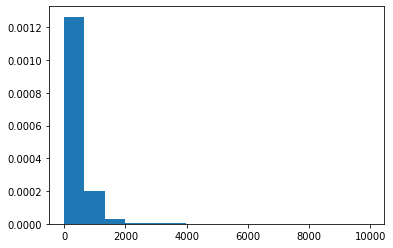

In [20]:
lens = [len(raw) for raw in news['text_preproc']]
plt.hist(lens, density=True, bins=15)

Ага, ну основная длина текстов - до 4000, но давайте посмотрим на самый длинный.

In [21]:
max(lens)

9938

Ну вот, так дело не пойдёт. У нас есть супер-длинные тексты. Надо сделать покороче. Возьмём покороче - 512. 

In [22]:
max_len = 512

Нам нужен гугловский pre-trained w2v.

In [23]:
!wget https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz

--2021-12-22 09:07:02--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.192.136
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.192.136|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1647046227 (1.5G) [application/x-gzip]
Saving to: ‘GoogleNews-vectors-negative300.bin.gz’

GoogleNews-vectors- 100%[===================>]   1.53G  16.7MB/s    in 97s     

2021-12-22 09:08:40 (16.1 MB/s) - ‘GoogleNews-vectors-negative300.bin.gz’ saved [1647046227/1647046227]



In [24]:
import gensim

google_news_path = "GoogleNews-vectors-negative300.bin.gz"
w2v = gensim.models.KeyedVectors.load_word2vec_format(google_news_path, binary=True)

В статье написано так: "We also initialize the word vector for the unknown words from the uniform distribution [-0.25, 0.25]", мы так и делаем 

In [25]:
weights = np.zeros((len(word2id), 300))
for word, i in word2id.items(): 
    try:
        weights[i] = w2v[word]    
    except KeyError:
        weights[i] = np.random.uniform(-0.25, 0.25, 300)

In [26]:
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from torch.nn.utils.rnn import pad_sequence

In [27]:
weights = torch.FloatTensor(weights)

In [28]:
class MyDataset(Dataset):

    def __init__(self, dataset, word2id, DEVICE):
        self.dataset = dataset['text_preproc'].values
        self.word2id = word2id
        self.length = dataset.shape[0]
        self.target = torch.Tensor(dataset['category'].values)
        self.device = DEVICE

    def __len__(self):
        return self.length

    def __getitem__(self, index): 
        tokens = self.dataset[index]
        ids = torch.LongTensor([self.word2id[token] if token in self.word2id \
                                else self.word2id['UNK'] for token in tokens][:max_len])
        y = [self.target[index]]
        return ids, y

    def collate_fn(self, batch): #этот метод можно реализовывать и отдельно,
    # он понадобится для DataLoader во время итерации по батчам
      ids, y = list(zip(*batch))
      padded_ids = torch.LongTensor(torch.stack([F.pad(idx, (1, max_len - len(idx))) for idx in ids], dim=0)).to(self.device)
      y = torch.Tensor(y).to(self.device) # tuple ([1], [0], [1])  -> Tensor [[1.], [0.], [1.]] 
      return padded_ids, y

In [29]:
DEVICE = 'cuda'

In [30]:
set_seed(42)
train_dataset = MyDataset(train_sentences, word2id, DEVICE)
train_sampler = RandomSampler(train_dataset)
train_iterator = DataLoader(train_dataset, collate_fn = train_dataset.collate_fn, sampler=train_sampler, batch_size=128)

In [31]:
set_seed(42)
test_dataset = MyDataset(test_sentences, word2id, DEVICE)
test_sampler = SequentialSampler(test_dataset)
test_iterator = DataLoader(test_dataset, collate_fn = test_dataset.collate_fn, sampler=test_sampler, batch_size=128)

Итак, согласно статье у нас архитектура следующая:
- CNN
    - 1 не полносвязный слой
    - нет пулинга
    - нелинейная фунция активации - ReLU
    - длина фильтра - 3
- LSTM
    - 1 слой
    - логистическая сигмоида, гиперболический тангенс
    - софтмакс
- Регуляризация
    - dropout
    - L2 weight regularization



In [32]:
class CLSTM(nn.Module):
    def __init__(self, vocab_size,
                 embedding_dim=300,
                 max_len=512,
                 output_dim=6, # кол-во классов
                 filter_sizes=[2, 3, 4],
                 num_filters=150,
                 lstm_layers=1,
                 memory_dim=150,
                 dropout_place=set([0]),
                 dropout_rate=0.5,
                 pretrained_weights=True,
                 weights=weights,
                 use_weights=True):
                # параметры по умолчанию из статьи

        super().__init__()

        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.max_len = max_len
        self.filter_sizes = filter_sizes
        self.max_features = max_len - max(filter_sizes) + 1
        self.num_filters = num_filters
        self.dropout_places = dropout_place # когда дропаут
        self.pretrained_weights = pretrained_weights
        if use_weights:
            # либо берём замороженные w2v
            self.embeddings = nn.Embedding.from_pretrained(weights)
        else:
            # либо генерим эмбеддинги
            self.embeddings = nn.Embedding(self.vocab_size, self.embedding_dim)
        # для каждого n в n-граммах делаем скрытый слой
        windows = []
        for f in self.filter_sizes:
            conv = nn.Conv1d(in_channels=self.embedding_dim,
                             out_channels=self.num_filters,
                             kernel_size=f,
                             padding='valid')
            windows.append(conv)
        self.windows = nn.ModuleList(windows)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout_rate)
        self.lstm = nn.LSTM(input_size=len(filter_sizes)* num_filters,
                            hidden_size=memory_dim, # размеры скрытых представлений
                            num_layers=lstm_layers, # сколько у нас lstm-ов
                            batch_first=True) #на первом месте в размерности - размерность батча
        self.linear = nn.Linear(memory_dim, output_dim)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        embeds = self.embeddings(x)
        embeds = embeds.transpose(1, 2)
        # по умолчанию дропаут до CNN 
        if 0 in self.dropout_places:
            embeds = self.dropout(embeds)
        # CNN
        feature_maps = []
        for conv in self.windows:
            feature_map = self.relu(conv(embeds))[:, :, :self.max_features]
            feature_maps.append(feature_map)
        feature_maps = torch.cat(feature_maps, 1).transpose(1,2)
        # LSTM
        _, (hidden_state, _)= self.lstm(feature_maps)
        # ещё можно дропаут после LSTM до софтмакса
        if 1 in self.dropout_places:
            embedded = self.dropout(hidden_state)
        logits = self.softmax(self.linear(torch.squeeze(hidden_state, 0)))
        
        return logits

In [35]:
! pip install torchmetrics

     |████████████████████████████████| 332 kB 2.1 MB/s 


In [36]:
from torchmetrics.functional import accuracy

In [56]:
def train(model, train_l, val_l, optimizer, criterion, device, metric, n_epochs):
    set_seed(42)
    losses = []
    metrics = []
    val_losses = []
    val_metrics = []
    print('Training...')
    for n_epoch in range(n_epochs):
        try:
            progress_bar = tqdm(total=len(train_l.dataset), desc='Epoch {}'.format(n_epoch + 1))
            model.train() # ставим модель в обучение, явно указываем, что сейчас надо будет хранить градиенты у всех весов
            epoch_loss = []
            epoch_metric = []
            for i, (texts, ys) in enumerate(train_l):  # итерируемся по батчам
                optimizer.zero_grad() # обнуляем градиенты
                ys = ys.flatten().type(torch.LongTensor).to(device)
                preds = model(texts) # прогоняем данные через модель
                loss = criterion(preds, ys) # считаем значение функции потерь
                loss.backward()  # считаем градиенты  
                optimizer.step() # обновляем веса 
                epoch_loss.append(loss.item()) # сохраняем значение функции потерь
                batch_metric = metric(preds.argmax(1).long(), ys.long(),
                              average='weighted', num_classes=6,
                              ignore_index=0)
                epoch_metric.append(batch_metric.cpu().numpy())
                progress_bar.set_postfix(loss=np.mean(losses[-100:]))
                progress_bar.update(texts.shape[0])
            progress_bar.close()
            val_loss, val_metric = evaluate(val_l, model, criterion, metric, device)
            val_losses.append(np.mean(val_loss))
            val_metrics.append(np.mean(val_metric))
            losses.append(np.mean(epoch_loss))
            metrics.append(np.mean(epoch_metric))
        except KeyboardInterrupt:
            progress_bar.close()
            break
    return losses, metrics, val_losses, val_metrics

In [57]:
def evaluate(dataloader, model, criterion, metric, device=DEVICE):
    epoch_loss = []
    epoch_metric = []
    model.eval() 
    with torch.no_grad():
        for i, (*x, y) in enumerate(dataloader):
            preds = model(*x)
            y = y.flatten().type(torch.LongTensor).to(device)
            loss = criterion(preds, y)
            epoch_loss.append(loss.item())
            batch_metric = metric(preds.argmax(1).long(), y.long(), average='weighted', num_classes=6, ignore_index=0)
            epoch_metric.append(batch_metric.cpu().numpy())     
    return epoch_loss, epoch_metric

In [39]:
from tqdm.auto import tqdm

In [58]:
model = CLSTM(vocab_size=len(word2id))
model = model.to(DEVICE)
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001, weight_decay=0.0001)
criterion = nn.CrossEntropyLoss()
n_epochs = 10
losses_train, metrics_train, losses_val, metrics_val = train(model,
                                                             train_iterator,
                                                             test_iterator,
                                                             optimizer,
                                                             criterion,
                                                             n_epochs=n_epochs,
                                                             metric=accuracy,
                                                             device=DEVICE)

Training...


Epoch 1:   0%|          | 0/18784 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 2:   0%|          | 0/18784 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/18784 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/18784 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/18784 [00:00<?, ?it/s]

Epoch 6:   0%|          | 0/18784 [00:00<?, ?it/s]

Epoch 7:   0%|          | 0/18784 [00:00<?, ?it/s]

Epoch 8:   0%|          | 0/18784 [00:00<?, ?it/s]

Epoch 9:   0%|          | 0/18784 [00:00<?, ?it/s]

Epoch 10:   0%|          | 0/18784 [00:00<?, ?it/s]

In [54]:
def plot_losses(losses, val_losses):
    plt.plot(losses)
    plt.plot(val_losses)
    plt.title('Loss value')
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper right')
    plt.show()

def plot_metrics(metrics, val_metrics):
    plt.plot(metrics)
    plt.plot(val_metrics)
    plt.title('Accuracy score')
    plt.ylabel('Accuracy score')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper right')
    plt.show()

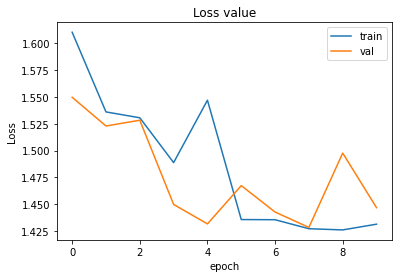

In [59]:
plot_losses(losses_train, losses_val)

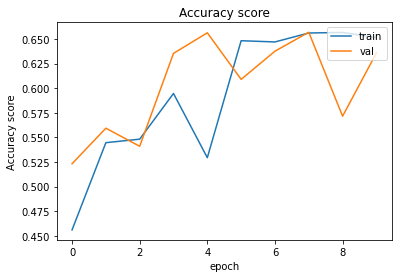

In [60]:
plot_metrics(metrics_train, metrics_val)

Ну, так себе... Есть подозрение, что классы не сбалансированы

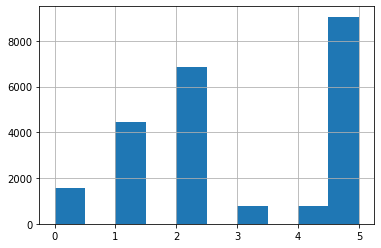

In [61]:
news['category'].hist()

Супер, 5 класса больше чем 3 или 4 в 9 раз... Ладно, что ж, значит, попробуем что-нибудь с этим сделать

## Задание 4 + 5.
Поставьте эксперименты с разными параметрами и особенностями архитектуры (регуляризация, паддинг, векторизация, драпаут и тд, в статье подробно описан смысл этих операций и что конкретно делали, загуглите как это имплементировано в торче) так как описано в статье (там есть подробное описание в разделе 5.2 Experimental Settings). Оцените результаты экспериментов также, как это сделали в статье.

### 1. Меняем фильтры

Почему я поставила по 5 эпох? Я думала так: надо перепробовать 7 разных фильтров, если каждая эпоха у меня проходила примерно за минуту, то если оставлю 10 эпох, у меня будет всё это дело обучаться 7*10=70 минут, а если оставлю по 5, то 35 минут.

В итоге чем меньше количество фильтров, тем быстрее всё обучается, т.е. можно было и побольше эпох оставить, но уже не хочется заново всё запускать

In [63]:
def change_parameters(weights, word2id, DEVICE):
    results = []
    filters = [[2], [3], [4], [2, 3], [3, 4], [2, 4], [2, 3, 4]]

    for f in filters:
        model = CLSTM(weights=weights, vocab_size=len(word2id),
                        filter_sizes=f)
        optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001,
                                        weight_decay=0.0001)
        criterion = nn.CrossEntropyLoss()
        model = model.to(DEVICE)

        print('*****')
        print('Filters:', f)

        losses_train, metrics_train, losses_val, metrics_val = train(model,
                                                                     train_iterator,
                                                                     test_iterator,
                                                                     optimizer,
                                                                     criterion,
                                                                     n_epochs=5,
                                                                     metric=accuracy,
                                                                     device=DEVICE)

        results.append({'filter_types': f,
                        'train_losses': losses_train,
                        'train_accs': metrics_train,
                        'val_losses': losses_val,
                        'val_accs': metrics_val,
                        'mean_acc': np.mean(metrics_val[-1])})
    return results

In [64]:
change_filters = change_parameters(weights, word2id, DEVICE)

*****
Filters: [2]
Training...


Epoch 1:   0%|          | 0/18784 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 2:   0%|          | 0/18784 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/18784 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/18784 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/18784 [00:00<?, ?it/s]

*****
Filters: [3]
Training...


Epoch 1:   0%|          | 0/18784 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/18784 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/18784 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/18784 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/18784 [00:00<?, ?it/s]

*****
Filters: [4]
Training...


Epoch 1:   0%|          | 0/18784 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/18784 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/18784 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/18784 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/18784 [00:00<?, ?it/s]

*****
Filters: [2, 3]
Training...


Epoch 1:   0%|          | 0/18784 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/18784 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/18784 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/18784 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/18784 [00:00<?, ?it/s]

*****
Filters: [3, 4]
Training...


Epoch 1:   0%|          | 0/18784 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/18784 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/18784 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/18784 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/18784 [00:00<?, ?it/s]

*****
Filters: [2, 4]
Training...


Epoch 1:   0%|          | 0/18784 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/18784 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/18784 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/18784 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/18784 [00:00<?, ?it/s]

*****
Filters: [2, 3, 4]
Training...


Epoch 1:   0%|          | 0/18784 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/18784 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/18784 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/18784 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/18784 [00:00<?, ?it/s]

<BarContainer object of 7 artists>

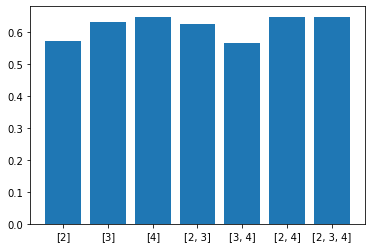

In [66]:
names = []
values = []
for r in change_filters:
    names.append(str(r['filter_types']))
    values.append(r['mean_acc'])
plt.bar(names, values)

У нас вообще не как в статье, но это ок, ведь данные разные. В целом походу разницы особо нет, какие выбирать, лучшие - [4], [2, 4], [2, 3, 4]. Их оставим для следующих экспериментов. [2, 3, 4] уже брали, давайте возьмём [2, 4].

### 2. Меняем их количество

Вот ещё вариант: *For TREC, the number of filters is set to be 300 and the memory dimension is set to be 300.*

In [67]:
model = CLSTM(vocab_size=len(word2id),
              filter_sizes=[2, 4],
              num_filters=300,
              memory_dim=300)
model = model.to(DEVICE)
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001, weight_decay=0.0001)
criterion = nn.CrossEntropyLoss()
n_epochs = 8
losses_train, metrics_train, losses_val, metrics_val = train(model,
                                                             train_iterator,
                                                             test_iterator,
                                                             optimizer,
                                                             criterion,
                                                             n_epochs=n_epochs,
                                                             metric=accuracy,
                                                             device=DEVICE)

Training...


Epoch 1:   0%|          | 0/18784 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 2:   0%|          | 0/18784 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/18784 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/18784 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/18784 [00:00<?, ?it/s]

Epoch 6:   0%|          | 0/18784 [00:00<?, ?it/s]

Epoch 7:   0%|          | 0/18784 [00:00<?, ?it/s]

Epoch 8:   0%|          | 0/18784 [00:00<?, ?it/s]

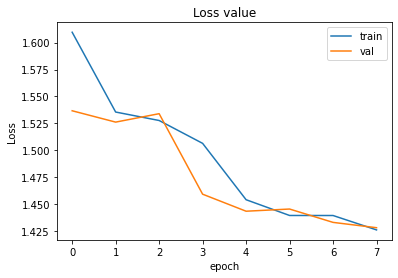

In [68]:
plot_losses(losses_train, losses_val)

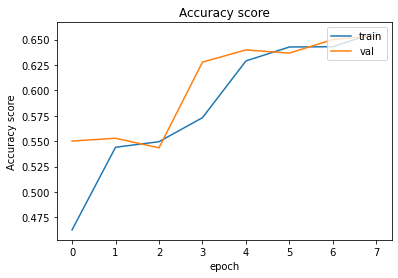

In [69]:
plot_metrics(metrics_train, metrics_val)

Кажется, стало получше.

### 3. Дропаут

Поменяем и места, в которых делаем дропаут, и его значение. Оставим остальные параметры как в прошлом эксперименте.

In [70]:
def search_dropout(weights, word2id, DEVICE):
    results = []
    for rate in [0.3, 0.5]:
        print('***********')
        print('dropout_rate = ', rate)
        for place in [set([0]), set([1]), set([0,1])]:
            print('----------')
            if place==set([0]):
                print('дропаут до CNN')
            elif place==set([1]):
                print('дропаут после LSTM пeред softmax')
            else:
                print('дропаут дважды')
            model = CLSTM(vocab_size=len(word2id),
                        filter_sizes=[2, 4],
                        num_filters=300,
                        memory_dim=300,
                        dropout_place=place,
                        dropout_rate=rate
                        )
            model = model.to(DEVICE)
            optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001, weight_decay=0.0001)
            criterion = nn.CrossEntropyLoss()
            n_epochs = 5
            losses_train, metrics_train, losses_val, metrics_val = train(model,
                                                                        train_iterator,
                                                                        test_iterator,
                                                                        optimizer,
                                                                        criterion,
                                                                        n_epochs=n_epochs,
                                                                        metric=accuracy,
                                                                        device=DEVICE)
            results.append({'rate': rate,
                            'place': place,
                            'losses_train': losses_train,
                            'metrics_train': metrics_train,
                            'losses_val':losses_val,
                            'metrics_val': metrics_val,
                            'mean_acc': np.mean(metrics_val[-1])})
    return results

In [71]:
change_dropout = search_dropout(weights, word2id, DEVICE)

***********
dropout_rate =  0.3
----------
дропаут до CNN
Training...


Epoch 1:   0%|          | 0/18784 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 2:   0%|          | 0/18784 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/18784 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/18784 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/18784 [00:00<?, ?it/s]

----------
дропаут после LSTM пeред softmax
Training...


Epoch 1:   0%|          | 0/18784 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/18784 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/18784 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/18784 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/18784 [00:00<?, ?it/s]

----------
дропаут дважды
Training...


Epoch 1:   0%|          | 0/18784 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/18784 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/18784 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/18784 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/18784 [00:00<?, ?it/s]

***********
dropout_rate =  0.5
----------
дропаут до CNN
Training...


Epoch 1:   0%|          | 0/18784 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/18784 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/18784 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/18784 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/18784 [00:00<?, ?it/s]

----------
дропаут после LSTM пeред softmax
Training...


Epoch 1:   0%|          | 0/18784 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/18784 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/18784 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/18784 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/18784 [00:00<?, ?it/s]

----------
дропаут дважды
Training...


Epoch 1:   0%|          | 0/18784 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/18784 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/18784 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/18784 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/18784 [00:00<?, ?it/s]

Отлично, серия ~~Анатомии страсти~~ экспериментов успешно завершена.

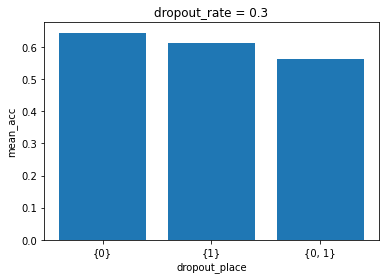

In [75]:
names = []
values = []
for r in change_dropout:
    if r['rate'] == 0.3:
        names.append(str(r['place']))
        values.append(r['mean_acc'])
plt.bar(names, values)
plt.title('dropout_rate = 0.3')
plt.ylabel('mean_acc')
plt.xlabel('dropout_place')
plt.show()

Ага, при dropout_rate, равном 0.3, лучший результат - если ставить его до CNN. Чему тут равно accuracy?

In [77]:
for r in change_dropout:
    if r['rate']==0.3 and str(r['place'])=='{0}':
        print(r['mean_acc'])

0.6440462


Text(0.5, 0, 'dropout_place')

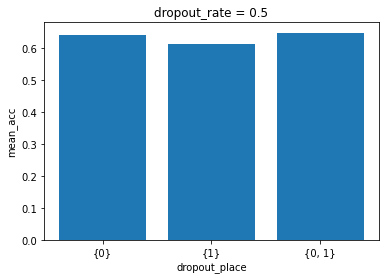

In [76]:
names = []
values = []
for r in change_dropout:
    if r['rate'] == 0.5:
        names.append(str(r['place']))
        values.append(r['mean_acc'])
plt.bar(names, values)
plt.title('dropout_rate = 0.5')
plt.ylabel('mean_acc')
plt.xlabel('dropout_place')

In [79]:
for r in change_dropout:
    if r['rate']==0.5 and str(r['place'])=='{0, 1}':
        print(r['mean_acc'])

0.6474684


Итого, лучший вариант - dropout_rate = 0.5, происходить он должен дважды

## Задание 6.
Напишите выводы (это должно быть похоже на раздел Results and Model Analysis только не нужно сравнивать с другими моделями, как это делают авторы статьи, сравнивайте только результаты своих экспериментов, потому что там цифры на других датасетах. Да писать так много тоже не нужно, но у вас и должно получиться меньше потому что не будет сравнения).

Какие варианты мы пробовали:


1.   Фильтры - единички, пары и тройки из *2, 3, 4*. Лучшим вариантом оказались **[4], [2, 4], [2, 3, 4]**.
2.   Количество фильтров и memory_dim. В нашем случае лучшие - **300** и **300** соответственно.
3.   Дропаут и в каком месте его применять - лучше **и до CNN, и между LSTM и softmax'ом**.



В целом, качество у нас, конечно, не очень (accuracy в районе 0,65). Пришлось уменьшать количество эпох на экспериментах, чтобы побыстрее было, думаю, увеличение количества эпох всё же могло бы немного помочь.

Из того, что ещё не похоже на статью - нам пришлось сильно урезать максимальную длину предложений, потому что даже с маленькими батчами не влезло бы. Кроме того, наш датасет всё-таки несблансирован по классам, потому модели зачастую проще предсказать просто самый многочисленный класс.

Ещё есть параметры, которые мы не меняли - регуляризация, оптимизатор. Кажется, можно ещё с кросс-энтропией что-нибудь сделать.